# House Prices : Advanced Regression Techniques 
## W207 - Final Project 
#### _Yatin Majmudar, Anu Sankar, Eugene Tang_

## Introduction

The Kaggle Competition Dataset of Iowa House Prices was originally compiled by Dean De Cock as  Ames Housing dataset  for use in data science education.  This dataset contains home sales made between 2006 and 2010.  The goal of this project is to use the features of a residential home to predict the sales price for each house ("SalePrice" variable) in the test datatset. Through this project, we hope to get more familiar with working with different types of features as well as different types of machine learning algorithms. The link to the Kaggle competition can be found here https://www.kaggle.com/c/house-prices-advanced-regression-techniques

## Import Python Libraries

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

from collections import defaultdict
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

/Users/eugenetang/miniconda3/envs/W207/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/Users/eugenetang/miniconda3/envs/W207/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Load Dataset

In [2]:
df_orig_train = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQiCWq7slPBno1PMTxXVkm1_-LmWWg66wo3HiMpVjrMmygSgpuyCKqHQ8czWSTtfIJlJArs0bQUYYH7/pub?output=csv')
df_test = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQRoR28pPBRJzuSczWzpS9fha3gS20Ycx_vzB1BALq8IVs6FdgRFAtfoqKTw-Rv26ScGQzx5cMXcKpG/pub?output=csv')

We split the original training data into two datasets: 70% as training data and 30% as development data.

In [3]:
# for consistency
np.random.seed(seed=37)

# add some additional variables of interest. Of note, we want to add how old the house is before it was sold
# and a logarithm of the sale price as a potential predictor.
df_orig_train['LogSalePrice'] = np.log(df_orig_train['SalePrice'])
df_orig_train['BuiltAge'] = df_orig_train['YrSold'] - df_orig_train['YearBuilt']
df_orig_train['RemodelAge'] = df_orig_train['YrSold'] - df_orig_train['YearRemodAdd']
df_test['BuiltAge'] = df_test['YrSold'] - df_test['YearBuilt']
df_test['RemodelAge'] = df_test['YrSold'] - df_test['YearRemodAdd']

# use 70% of data as training data; remainder 30% as development data
train_mask = np.random.rand(len(df_orig_train)) < 0.7
df_train = df_orig_train[train_mask]
df_dev = df_orig_train[~train_mask]

# drop Id also because it should not be a useful predictor
train_predictors = df_train.drop(['LogSalePrice', 'SalePrice', 'Id'], axis='columns')
train_sale_prices = df_train['SalePrice']
train_sale_prices_log = df_train['LogSalePrice']
dev_predictors = df_dev.drop(['LogSalePrice', 'SalePrice', 'Id'], axis='columns')
dev_sale_prices = df_dev['SalePrice']
dev_sale_prices_log = df_dev['LogSalePrice']
test_predictors = df_test.drop(['Id'], axis='columns')

print('Our dataset has {} explanatory variables (we added 2)'.format(train_predictors.shape[1]))
print('We have {} training data points'.format(train_predictors.shape[0]))
print('We have {} development data points'.format(dev_predictors.shape[0]))
print('We have {} testing data points'.format(df_test.shape[0]))

Our dataset has 81 explanatory variables (we added 2)
We have 1037 training data points
We have 423 development data points
We have 1459 testing data points


## Exploratory Data Analysis

There are 79 explanatory variables in the training dataset.  The original training dataset has 1460 rows of which we have 1037 rows for training and  423 rows for development.  The testing dataset has 1459 rows. 

We begin the EDA by taking a cursory look at the data that we have loaded.


In [4]:
train_predictors.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,BuiltAge,RemodelAge
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,5,2007,WD,Normal,31,31
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,9,2008,WD,Normal,7,6
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,91,36
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,12,2008,WD,Normal,8,8
5,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,MnPrv,Shed,700,10,2009,WD,Normal,16,14


In [5]:
dev_predictors.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,BuiltAge,RemodelAge
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,2,2008,WD,Normal,5,5
7,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,Shed,350,11,2009,WD,Normal,36,36
9,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,1,2008,WD,Normal,69,58
10,20,RL,70.0,11200,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,2,2008,WD,Normal,43,43
13,20,RL,91.0,10652,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,8,2007,New,Partial,1,0


### Missing Data
We notice above that there are some columns that have missing or null values.  Let's check those further.

In [6]:
print('Columns with NAs (in the entire training dataset):')
(df_orig_train.isnull().sum()[df_orig_train.isnull().sum() > 0]).sort_values(ascending = False)

Columns with NAs (in the entire training dataset):


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

There are also some NAs in the testing dataset.

In [8]:
print('Columns with NAs in the testing dataset: ')
(df_test.isnull().sum()[df_test.isnull().sum() > 0]).sort_values(ascending = False)

Columns with NAs in the testing dataset: 


PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageCond        78
GarageQual        78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
KitchenQual        1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
dtype: int64

Because sklearn does not work well with NA values, we will try to fill these values. We look at the documentation for the meaning of each of the columns to help inform how to fill them in. For the lot frontage, we will take the median of the value to be more robust toward outliers.

We create a method to fill in the NAs below.

In [9]:
def fill_in_nas(features, training_features):
    feature_to_substitution = {
        'PoolQC': 'None',       # NA = No pool
        'MiscFeature': 'None',  # NA = None
        'Alley': 'None',        # NA = No alley
        'Fence': 'None',        # NA = No fence
        'FireplaceQu': 'None',  # NA = No fireplace
        'LotFrontage': training_features['LotFrontage'].median(), # take the median lot frontage if it does not have any value
        'GarageYrBlt': 0,       # NA = No garage
        'GarageType': 'None',   # NA = No garage
        'GarageFinish': 'None', # NA = No garage
        'GarageQual': 'None',   # NA = No garage
        'GarageCond': 'None',   # NA = No garage
        'BsmtFinType2': 'None', # NA = No basement
        'BsmtExposure': 'None', # NA = No basement
        'BsmtFinType1': 'None', # NA = No basement
        'BsmtCond': 'None',     # NA = No basement
        'BsmtQual': 'None',     # NA = No basement
        'MasVnrArea': 0,        # NA = No masonry veneer
        'MasVnrType': 'None',   # NA = No masonry veneer
        'Electrical': 'Unknown', # NA is unspecified here
        'BsmtFullBath': 0,       # We assume there is no basement
        'BsmtHalfBath': 0,       # We assume there is no basement
        'Utilities': 'Unknown',  # NA is not specified
        'Functional': 'Typ',     # NA is not specified, so we use typical, which is the "normal" case
        'Exterior2nd': 'Other',  # NA is not specified, so we use other
        'Exterior1st': 'Other',  # NA is not specified, so we use other
        'SaleType': 'Oth',       # NA is not specified, so we use other
        'BsmtFinSF1': 0,         # We assume there is no basement
        'BsmtFinSF2': 0,         # We assume there is no basement
        'BsmtUnfSF': 0,          # We assume there is no basement
        'KitchenQual': 'Unknown',# NA is not specified (TA ? -Typical / Average?)
        'GarageCars': 0,         # There is only one row with an NaN for garage, and it is a house with no garage
        'GarageArea': 0,         # There is only one row with an NaN for garage, and it is a house with no garage
        'TotalBsmtSF': 0         # We assume there is no basement
    }
    # fill in NAs
    for feature, replacement in feature_to_substitution.items():
        features[feature] = features[feature].fillna(replacement)

In [10]:
fill_in_nas(train_predictors, training_features=train_predictors)
fill_in_nas(dev_predictors, training_features=train_predictors)
fill_in_nas(test_predictors, training_features=train_predictors)

### Sale Prices
The goal of the assignment is to predict home prices, so we do a brief inspection of sale prices. 

#### Histogram of sale prices
Here we see that most homes are sold for ~$160k. The distribution has a long right tail, which makes sense there will be a few very expensive houses.

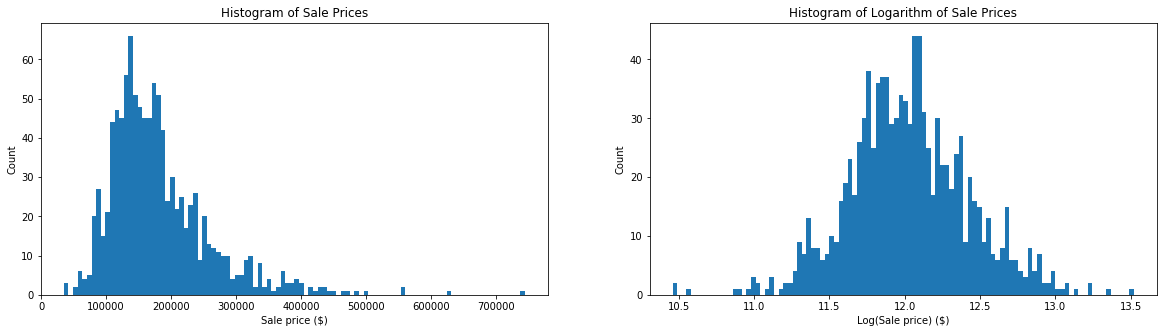

In [11]:
plt.figure(figsize = (20,5))

plt.subplot(1,2,1)
plt.hist(train_sale_prices, bins=100)
plt.title("Histogram of Sale Prices")
plt.xlabel("Sale price ($)")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(train_sale_prices_log, bins=100)
plt.title("Histogram of Logarithm of Sale Prices")
plt.xlabel("Log(Sale price) ($)")
plt.ylabel("Count")

plt.show()

In [12]:
train_sale_prices.describe()

count      1037.000000
mean     181002.148505
std       78318.007478
min       34900.000000
25%      129500.000000
50%      165000.000000
75%      213250.000000
max      745000.000000
Name: SalePrice, dtype: float64

Given the high skew in the prices, we also consider trying to predict the logarithm of the sale price instead of the raw sale price. The Kaggle competition also evaluates performance based on the rmse of the logarithm of the sale prices. Below we can see that this has corrected the skew a lot.

### Feature Types
Here we get a list of the categorical and numeric values. We do this by manual inspection of the variables (e.g. some numeric variables such as 'OverallQual' may be better treated as an ordinal variable rather than a numeric one).

In [13]:
# list out the categorical features and values
# categories
categorical_features = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 
                        'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
                        'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
                        'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
                        'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating',
                        'CentralAir', 'Electrical', 'GarageType', 'MiscFeature',
                        'SaleType', 'SaleCondition', 'MoSold', 'YrSold']
# features that have some sense of order
ordinal_features = ['LotShape', 'OverallQual', 'OverallCond', 'ExterQual', 
                    'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                    'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
                    'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 
                    'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']
# numeric features
numeric_features = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
                    'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                    'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                    'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
                    'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
                    'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
                    'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
                    'PoolArea', 'MiscVal', 'RemodelAge', 'BuiltAge']

### Correlation Matrix

We create a correlation matrix for the numeric features to understand the correlation among features and the correlation between the features and the sale price. Here we see that many features are highly correlated as expected (e.g. GarageYrBlt and YrBlt). We see that many features representing the quality of the home is positively correlated with the sale price. When looking at the top correlated features to sale price, we find that a lot of the top correlated features are more highly linearly correlated with the logarithm of the sale price than the sale price itself. This gives us further motivation to predict the logarithm of the sale price directly.

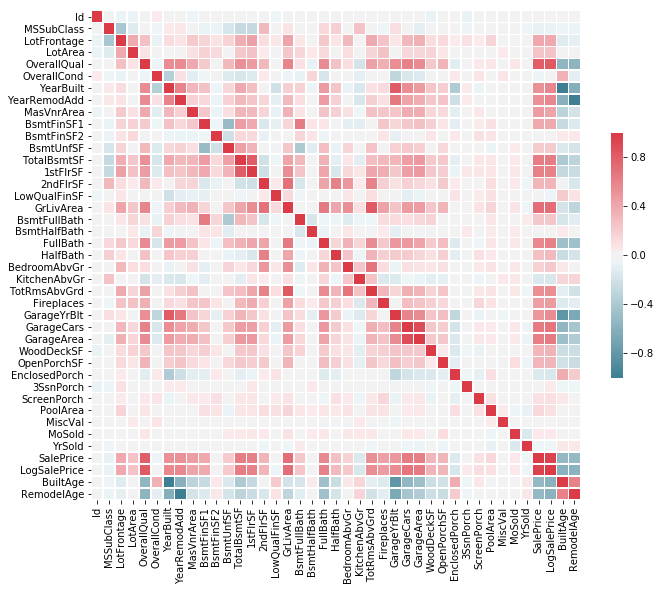

In [14]:
def get_correlations():
    corr_matrix = df_train.corr()
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr_matrix, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
get_correlations()

In [15]:
def get_top_correlated_features():
    sale_price_correlations = np.corrcoef(df_train[['SalePrice'] + numeric_features], rowvar=False)[0]
    corrs = np.nan_to_num(sale_price_correlations[1:])
    most_correlated = sorted(zip(corrs[~np.isnan(corrs)], range(len(corrs[~np.isnan(corrs)]))), key=lambda x:np.abs(x[0]), reverse=True)
    print('Top 10 most correlated features to sale price:')
    print('Feature              | Correlation')
    print('-----------------------------------------')
    for corr, f_index in most_correlated[0:10]:
        print('{:20} | {:.6f}'.format(numeric_features[f_index], corr))
    print()

    log_sale_price_correlations = np.corrcoef(df_train[['LogSalePrice'] + numeric_features], rowvar=False)[0]
    corrs = np.nan_to_num(log_sale_price_correlations[1:])
    most_correlated = sorted(zip(corrs[~np.isnan(corrs)], range(len(corrs[~np.isnan(corrs)]))), key=lambda x:np.abs(x[0]), reverse=True)
    print('Top 10 most correlated features to logarithm of sale price:')
    print('Feature              | Correlation')
    print('-----------------------------------------')
    for corr, f_index in most_correlated[0:10]:
        print('{:20} | {:.6f}'.format(numeric_features[f_index], corr))
get_top_correlated_features()

Top 10 most correlated features to sale price:
Feature              | Correlation
-----------------------------------------
GrLivArea            | 0.717709
GarageCars           | 0.643723
TotalBsmtSF          | 0.637331
GarageArea           | 0.624664
1stFlrSF             | 0.613928
FullBath             | 0.577186
TotRmsAbvGrd         | 0.532412
RemodelAge           | -0.527717
YearRemodAdd         | 0.525928
BuiltAge             | -0.525519

Top 10 most correlated features to logarithm of sale price:
Feature              | Correlation
-----------------------------------------
GrLivArea            | 0.712920
GarageCars           | 0.681135
GarageArea           | 0.649390
TotalBsmtSF          | 0.635954
FullBath             | 0.610472
1stFlrSF             | 0.603654
BuiltAge             | -0.586980
YearBuilt            | 0.586125
RemodelAge           | -0.581344
YearRemodAdd         | 0.579664


In [16]:
def print_highly_correlated_predictors(n):
    corr_matrix = df_train.corr()
    column_list = corr_matrix.columns.values.tolist()
    top_correlations = {}
    for c in column_list:
        if 'SalePrice' in c or 'LogSalePrice' in c:
            continue
        # exclude the diagonal
        corr_matrix_without_Row_c = corr_matrix.drop([c], axis = 0)
        # find the the highest correlator
        max_correlator = corr_matrix_without_Row_c[c].idxmax()
        if 'SalePrice' in max_correlator or 'LogSalePrice' in max_correlator:
            continue
        # find the value of correlation
        max_correlated_value = corr_matrix_without_Row_c.loc[max_correlator, c]
        
        #store the correlation, if the reverse has not been stored
        if not max_correlator + "-" + c in top_correlations:
            top_correlations[c + "-" + max_correlator] = max_correlated_value
        #print(c, max_correlator, max_correlated_value)
    
    # sort dictionary - print top n
    print("Highly correlated predictors:")
    print("---------------------------------------")
    for key, value in sorted(top_correlations.items(), key = 
             lambda kv:(kv[1], kv[0]), reverse=True)[:n]:
        print ("{:25}: {:.6f}".format(key, value))

print_highly_correlated_predictors(20)

Highly correlated predictors:
---------------------------------------
GarageCars-GarageArea    : 0.891199
GrLivArea-TotRmsAbvGrd   : 0.824970
YearBuilt-GarageYrBlt    : 0.818122
TotalBsmtSF-1stFlrSF     : 0.808178
2ndFlrSF-GrLivArea       : 0.696936
BedroomAbvGr-TotRmsAbvGrd: 0.686697
YearRemodAdd-GarageYrBlt : 0.657631
FullBath-GrLivArea       : 0.653599
BsmtFinSF1-BsmtFullBath  : 0.644726
HalfBath-2ndFlrSF        : 0.614840
BuiltAge-RemodelAge      : 0.603085
BsmtUnfSF-TotalBsmtSF    : 0.441607
LotFrontage-1stFlrSF     : 0.438563
LotArea-LotFrontage      : 0.384604
EnclosedPorch-BuiltAge   : 0.378659
OverallCond-BuiltAge     : 0.349547
OpenPorchSF-GrLivArea    : 0.331065
MSSubClass-2ndFlrSF      : 0.310941
KitchenAbvGr-TotRmsAbvGrd: 0.262307
LowQualFinSF-BuiltAge    : 0.203828


### Univariate and Bivariate Analysis
Here we look at specific variables to observe relationships about them.

#### Numeric Variables

We see from the correlation matrix and heatmap that the variable 'GrLivArea' is the most positively correlated variable to the outcome variable 'SalePrice'.  The new columns 'BuiltAge', 'RemodelAge' are the most negatively correlated variables to 'SalePrice'.  The other variables that have high correlation to 'SalePrice' are : 'TotRmsAbvGrd', 'FullBath', 'Fireplaces', 'GarageCars', 'TotalBsmtSF', 'LotArea', '1stFlrSF'. Here we plot some charts to visualize these variable's distributions and relationships with SalePrice.

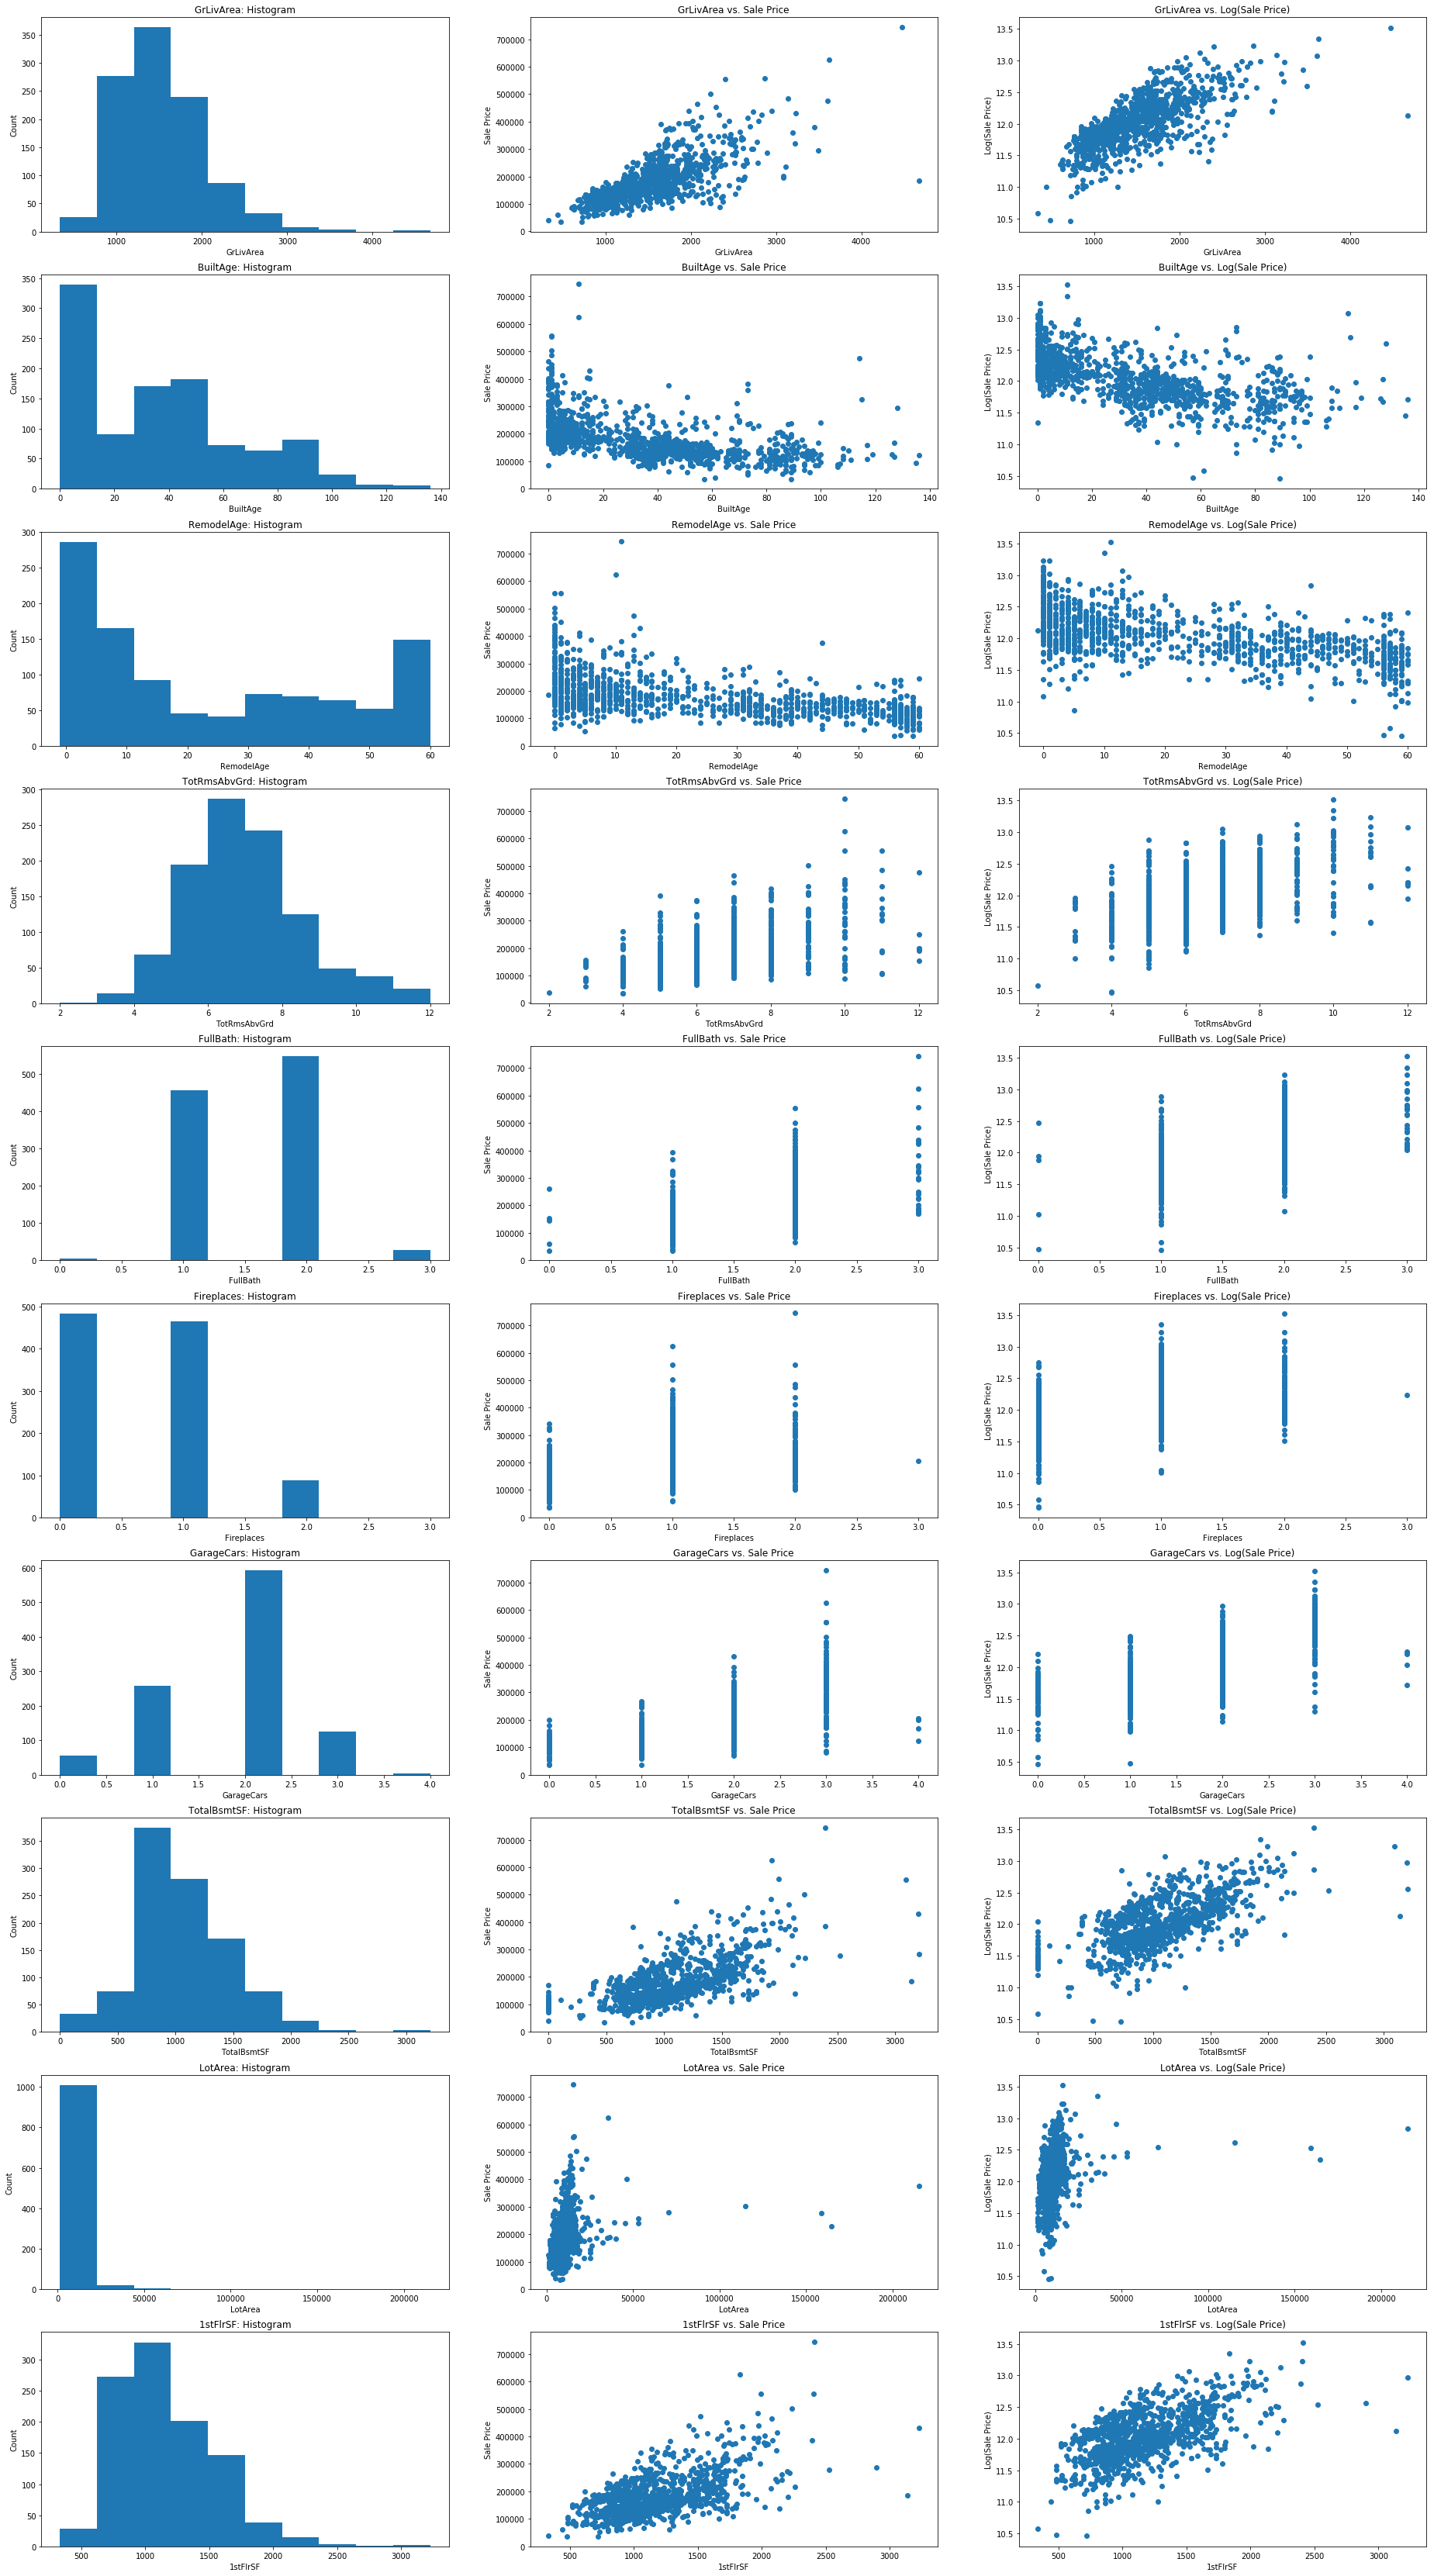

In [17]:
varList = ['GrLivArea','BuiltAge','RemodelAge','TotRmsAbvGrd','FullBath','Fireplaces','GarageCars','TotalBsmtSF','LotArea','1stFlrSF']

plt.figure(figsize = (32, 60))
i = 0
for v in varList:
    # histogram
    plt.subplot(len(varList), 3, 3*i + 1)
    plt.hist(df_train[v])
    plt.title(v + ": Histogram")
    plt.xlabel(v)
    plt.ylabel('Count')
    plt.axis('tight')
    
    # variable vs. Sale Price
    plt.subplot(len(varList), 3, 3*i + 2)
    plt.scatter(x = df_train[v], y = df_train['SalePrice'])
    plt.title(v + " vs. Sale Price")
    plt.axis('tight')
    plt.ylabel('Sale Price')
    plt.xlabel(v)
    
    # variable vs. Log(Sale Price)
    plt.subplot(len(varList), 3, 3*i + 3)
    plt.scatter(x = df_train[v], y = df_train['LogSalePrice'])
    plt.title(v + " vs. Log(Sale Price)")
    plt.axis('tight')
    plt.ylabel('Log(Sale Price)')
    plt.xlabel(v)

    i += 1

plt.show()

The numeric variables we explored above have a similar or a better linear relationship with log(SalePrice) (corroborating the numeric data presented above). This gives us further evidence to use log(SalePrice) as the target variable in our models. 

From the above histograms we can see that a lot of the area-related features are very skewed. From the histograms below, we can see that a lot of the area-based features are very skewed.

/Users/eugenetang/miniconda3/envs/W207/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/eugenetang/miniconda3/envs/W207/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


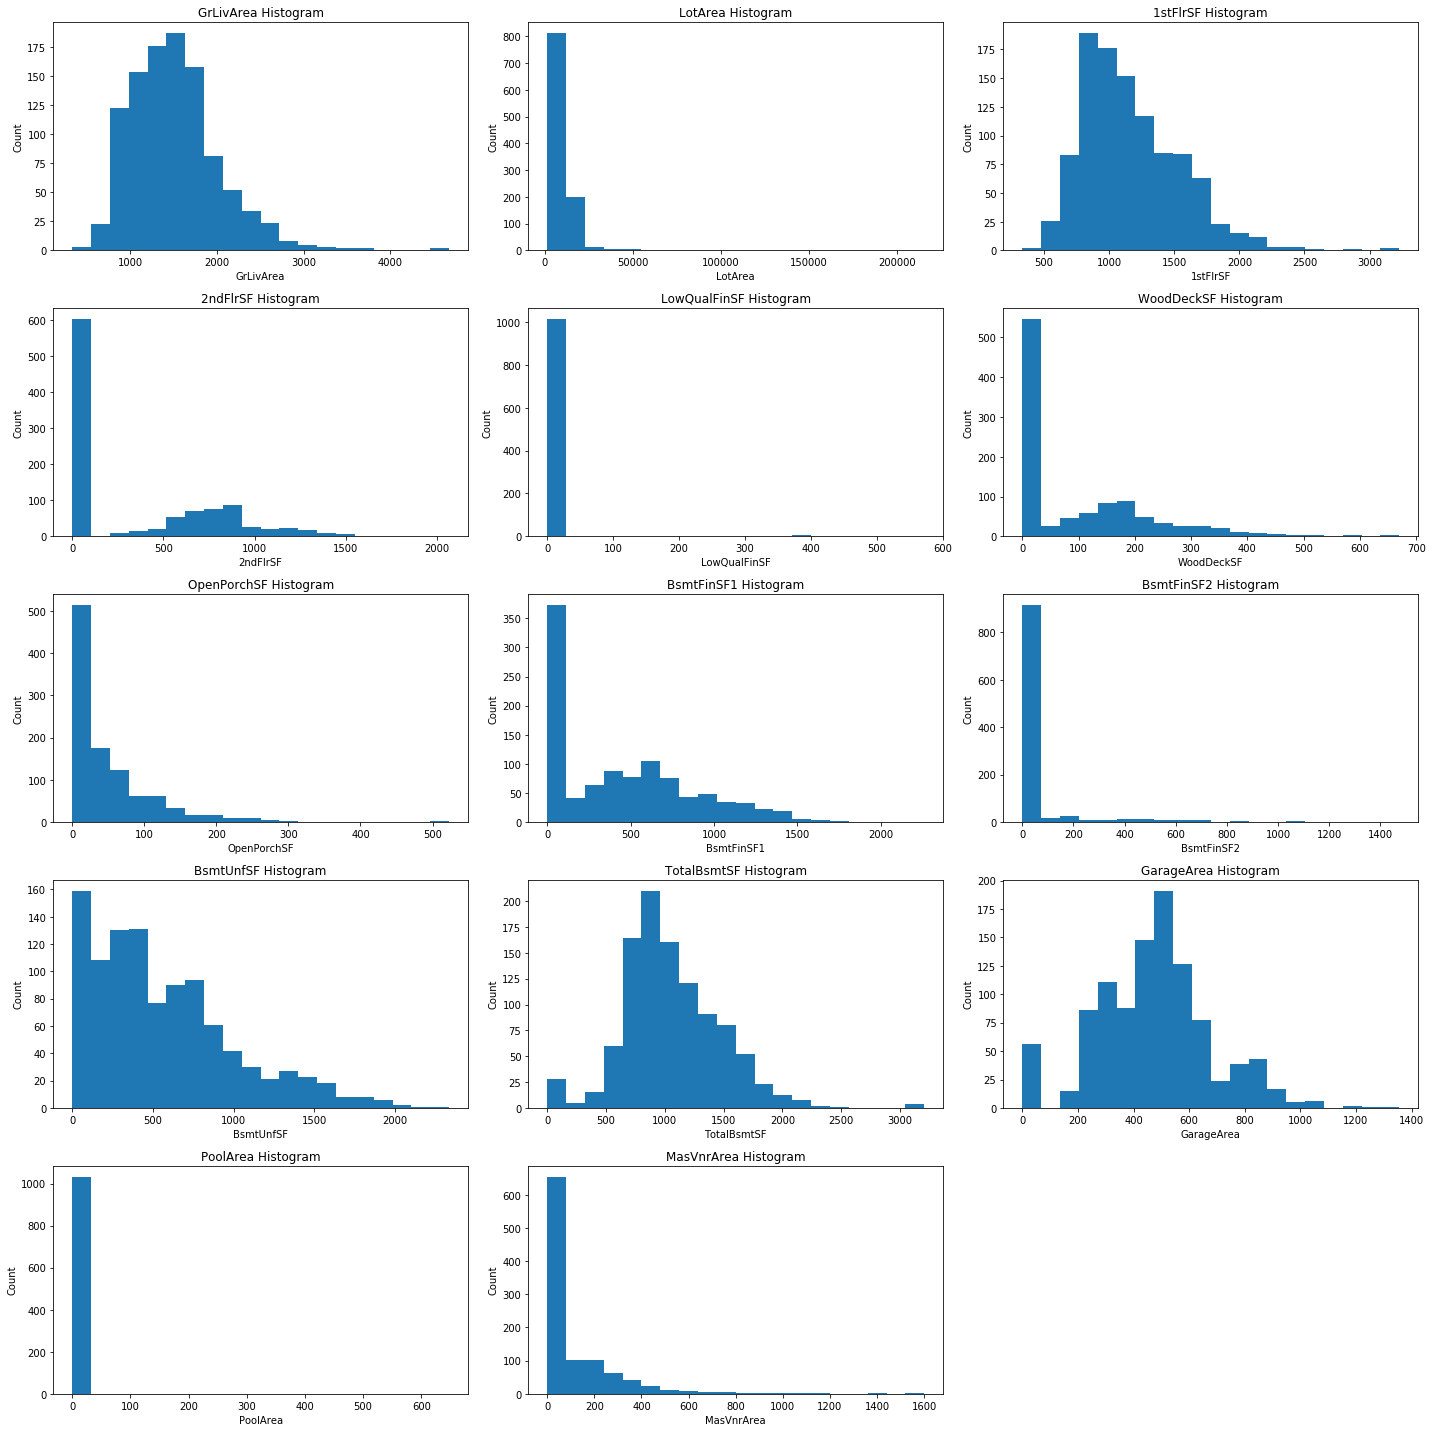

In [18]:
varList = ['GrLivArea', 'LotArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
           'WoodDeckSF', 'OpenPorchSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
           'TotalBsmtSF', 'GarageArea', 'PoolArea', 'MasVnrArea']
plt.figure(figsize = (20, 20))

for i,v in enumerate(varList):
    # histogram
    plt.subplot(len(varList)/3+1, 3, i+1)
    plt.hist(df_train[v], bins=20)
    plt.title('{} Histogram'.format(v))
    plt.xlabel('{}'.format(v))
    plt.ylabel('Count')
    plt.tight_layout()
plt.show()

We use the log-transform to help correct for some of that skew. The log transformation also makes sense in that it helps us interpret the results in a standard linear regression as a X change in the area will result in a Y change in price.

/Users/eugenetang/miniconda3/envs/W207/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/eugenetang/miniconda3/envs/W207/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


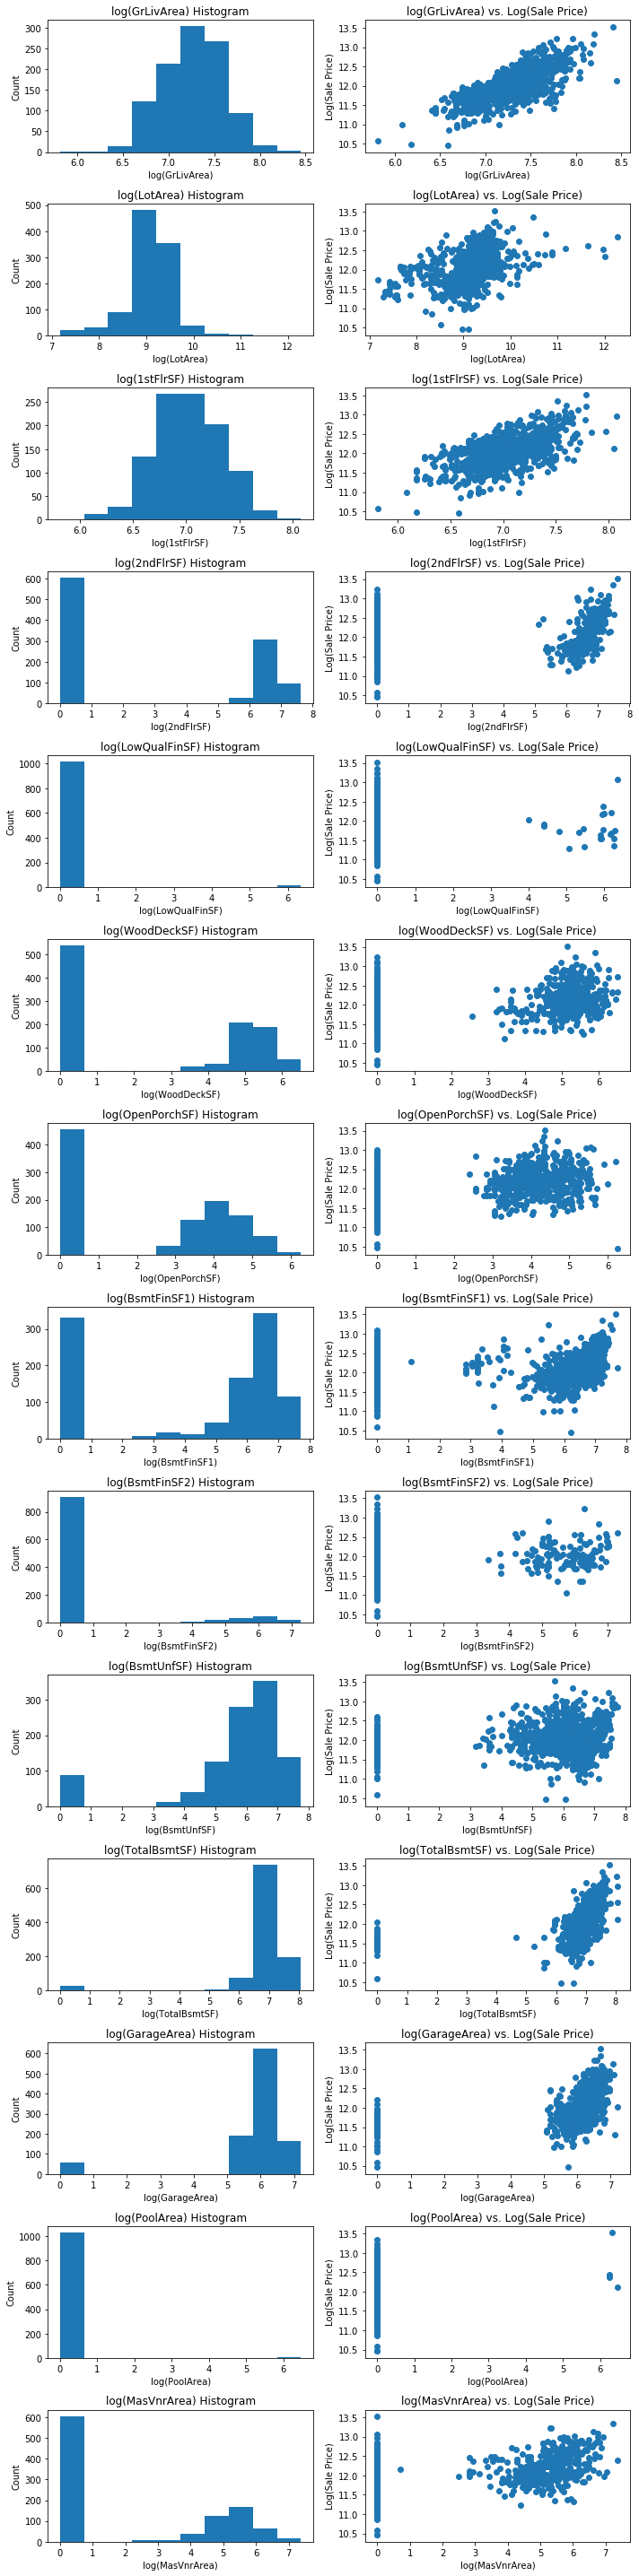

In [19]:
varList = ['GrLivArea', 'LotArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
           'WoodDeckSF', 'OpenPorchSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
           'TotalBsmtSF', 'GarageArea', 'PoolArea', 'MasVnrArea']

plt.figure(figsize = (10, 40))

i = 0
for v in varList:
    # histogram
    plt.subplot(len(varList), 2, 2*i + 1)
    plt.hist(np.log1p(df_train[v]))
    plt.title('log({}) Histogram'.format(v))
    plt.xlabel('log({})'.format(v))
    plt.ylabel('Count')
    plt.axis('tight')
    
    # variable vs. Log(Sale Price)
    plt.subplot(len(varList), 2, 2*i + 2)
    plt.scatter(x = np.log1p(df_train[v]), y = df_train['LogSalePrice'])
    plt.title("log(" + v + ") vs. Log(Sale Price)")
    plt.axis('tight')
    plt.ylabel('Log(Sale Price)')
    plt.xlabel("log(" + v + ")" )
    plt.tight_layout()

    i += 1

plt.show()

#### Categorical and Ordinal Variables

#### Neighborhood

Do different neighborhoods have different median sale prices? Here we see that the median price per neighborhood can vary from less than 100k dollars to over 300k dollars. The counts of houses sold per neighborhood also vary quite a bit. Noteably, one neighborhood ("Blueste") only has one house sale.

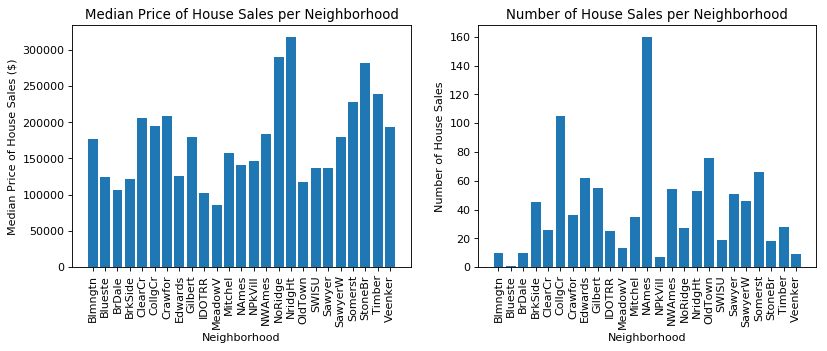

In [20]:
neighborhood_sale_prices = df_train.groupby('Neighborhood')['SalePrice'].median()
neighborhood_counts = df_train.groupby('Neighborhood')['SalePrice'].count()

neighborhoods = neighborhood_sale_prices.keys().tolist()

# plot counts of neighborhood sales and prices
plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
x = range(len(neighborhoods))
plt.bar(x, neighborhood_sale_prices)
plt.title('Median Price of House Sales per Neighborhood')
plt.xticks(x, neighborhoods, rotation='vertical')
plt.xlabel('Neighborhood')
plt.ylabel('Median Price of House Sales ($)')

plt.subplot(1,2,2)
plt.bar(x, neighborhood_counts)
plt.title('Number of House Sales per Neighborhood')
plt.xticks(x, neighborhoods, rotation='vertical')
plt.xlabel('Neighborhood')
plt.ylabel('Number of House Sales')
plt.show()

#### MSSubClass
Identifies the type of dwelling involved in the sale.  1-story (MSSubClass = 20) and  2-story (MSSubClass = 60) that 1946 or newer have sold the most.  

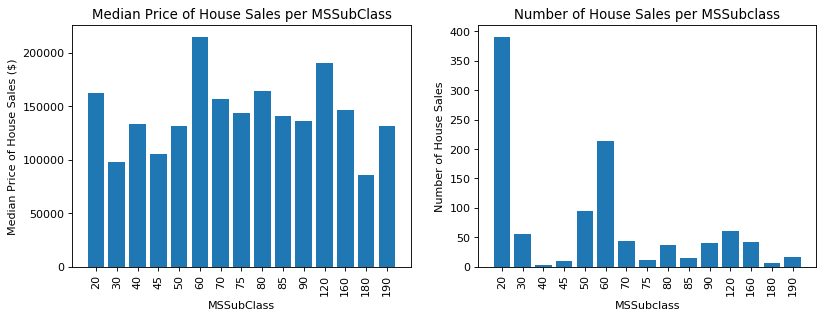

In [21]:
MSSubClass_sale_prices = df_train.groupby('MSSubClass')['SalePrice'].median()
MSSubclass_counts = df_train.groupby('MSSubClass')['SalePrice'].count()

MSSubClasses = MSSubClass_sale_prices.keys().tolist()

# plot counts of MSSubClass sales and prices
plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
x = range(len(MSSubClasses))
plt.bar(x, MSSubClass_sale_prices)
plt.title('Median Price of House Sales per MSSubClass')
plt.xticks(x, MSSubClasses, rotation='vertical')
plt.xlabel('MSSubClass')
plt.ylabel('Median Price of House Sales ($)')

plt.subplot(1,2,2)
plt.bar(x, MSSubclass_counts)
plt.title('Number of House Sales per MSSubclass')
plt.xticks(x, MSSubClasses, rotation='vertical')
plt.xlabel('MSSubclass')
plt.ylabel('Number of House Sales')
plt.show()

#### Month Sold
By plotting the count of houses sold and median price, we can see that there does seem to be a strong seasonality where most houses are sold in the summer, though it does not seem to affect median price much.

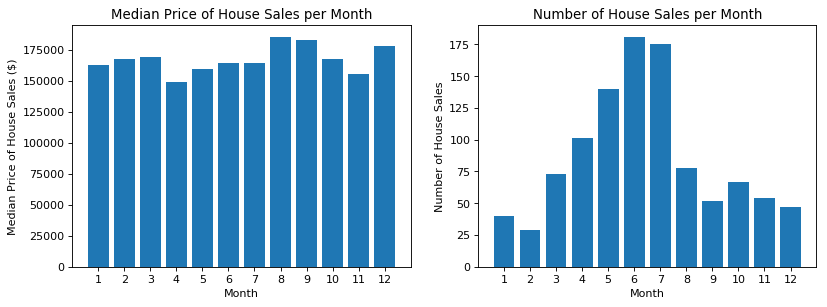

In [22]:
month_sold_sale_prices = df_train.groupby('MoSold')['SalePrice'].median()
month_sold_counts = df_train.groupby('MoSold')['SalePrice'].count()

months = month_sold_sale_prices.keys().tolist()

# plot counts of MSSubClass sales and prices
plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
x = range(len(months))
plt.bar(x, month_sold_sale_prices)
plt.title('Median Price of House Sales per Month')
plt.xticks(x, months)
plt.xlabel('Month')
plt.ylabel('Median Price of House Sales ($)')

plt.subplot(1,2,2)
plt.bar(x, month_sold_counts)
plt.title('Number of House Sales per Month')
plt.xticks(x, months)
plt.xlabel('Month')
plt.ylabel('Number of House Sales')
plt.show()

#### Overall Quality

Overall quality seems to correlate well with sale price and may be a good predictor to use. Given the strong linear correlation between the overall quality number and logarithm of sale price, we may even consider using Overall Quality as a numeric feature rather than a categorical one.

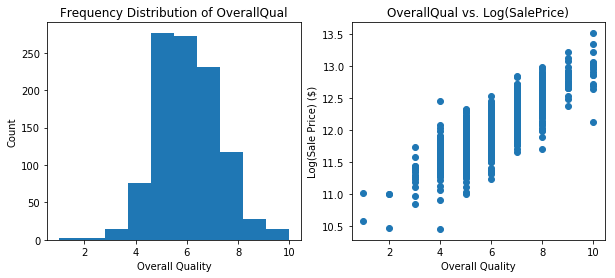

The correlation between Overall Quality and the logarithm of the sale price is 0.822521


In [23]:
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.hist(train_predictors.OverallQual)
plt.title('Frequency Distribution of OverallQual')
plt.xlabel('Overall Quality')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.scatter(x = train_predictors.OverallQual, y = train_sale_prices_log)
plt.title('OverallQual vs. Log(SalePrice)')
plt.xlabel('Overall Quality')
plt.ylabel('Log(Sale Price) ($)')

plt.show()

corr = np.corrcoef(train_predictors.OverallQual, train_sale_prices_log)
print('The correlation between Overall Quality and the logarithm of the sale price is {:.6f}'.format(corr[0][1]))

#### Overall Condition
The overall condition does not seem to correlate well with sale price.

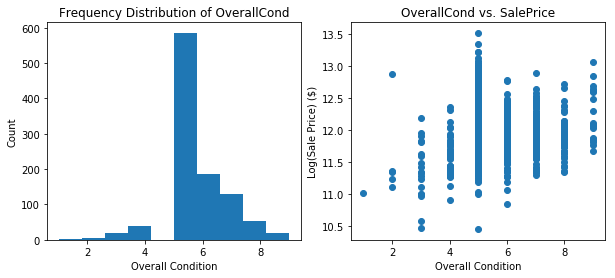

The correlation between Overall Condition and the logarithm of the sale price is -0.000900


In [24]:
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.hist(train_predictors.OverallCond)
plt.title('Frequency Distribution of OverallCond')
plt.xlabel('Overall Condition')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.scatter(x = train_predictors.OverallCond, y = train_sale_prices_log)
plt.title('OverallCond vs. SalePrice')
plt.xlabel('Overall Condition')
plt.ylabel('Log(Sale Price) ($)')
plt.show()

corr = np.corrcoef(train_predictors.OverallCond, train_sale_prices_log)
print('The correlation between Overall Condition and the logarithm of the sale price is {:.6f}'.format(corr[0][1]))

# Preprocess Data

In this section we preprocess the data for use in later sections.

### Feature Transformations
Based on the EDA above, we perform the following feature transformations (mainly related to area variables).

In [25]:
area_features = ['GrLivArea', 'LotArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
                 'WoodDeckSF', 'OpenPorchSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', 'GarageArea', 'PoolArea', 'MasVnrArea']
def log_transform_features(features, replace_original = False):
    for feature in area_features:
        features['Log{}'.format(feature)] = np.log1p(features[feature])
    if replace_original:
        features.drop(area_features, axis='columns', inplace=True)

# log transform train, dev and test data
log_transform_features(df_train)
log_transform_features(df_dev)
log_transform_features(df_test)

log_transform_features(train_predictors, replace_original = True)
log_transform_features(dev_predictors, replace_original = True)
log_transform_features(test_predictors, replace_original = True)


numeric_features += ['Log{}'.format(feature) for feature in area_features]
# remove area_features, as also, duplicate column names if any
numeric_features = list(set(numeric_features) - set(area_features))

/Users/eugenetang/miniconda3/envs/W207/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Create Dummy Variables
For our categorical features, to get them to work with the later algorithms, we have a function to create dummy variables here.

In [26]:
# get the features with categorical and ordinal features converted to dummy variables
def get_regression_features_with_dummy():
    train_regression_features = pd.DataFrame(index=train_predictors.index)
    dev_regression_features = pd.DataFrame(index=dev_predictors.index)
    # setup categorical/ordinal features
    for feature in (categorical_features + ordinal_features):

        # get dummies
        train_feature_dummies = pd.get_dummies(train_predictors[feature], prefix=feature, drop_first=True)
        dev_feature_dummies = pd.get_dummies(dev_predictors[feature], prefix=feature, drop_first=True)

        # only take the columns from the training dataset
        for col in train_feature_dummies.columns.tolist():
            train_regression_features[col] = train_feature_dummies[col]
            if col in dev_feature_dummies: 
                dev_regression_features[col] = dev_feature_dummies[col]
            else:
                # if the dev dataset doesn't have the column, fill it with zeroes
                dev_regression_features[col] = 0

    # add numeric features        
    for col in numeric_features:
        train_regression_features[col] = train_predictors[col]
        dev_regression_features[col] = dev_predictors[col]
    
    return train_regression_features, dev_regression_features

# scale the provided features
def scale_features(train_features, dev_features):
    ss = StandardScaler()
    train_features[numeric_features] = ss.fit_transform(train_features[numeric_features])
    dev_features[numeric_features] = ss.transform(dev_features[numeric_features])
    return ss, train_features, dev_features

In [27]:
def get_regression_feature_stats():
    train_predictors, dev_predictors = get_regression_features_with_dummy()
    print('After adding dummy variables and making log transforms, our models will run with {} features.'.format(train_predictors.shape[1]))
get_regression_feature_stats()

After adding dummy variables and making log transforms, our models will run with 298 features.


### Plotting Houses
Here we use PCA to visualize our training data. There do seem to be some houses that have characteristics that are very different from the rest while most houses seem to sit in the same category.

(1037, 298)


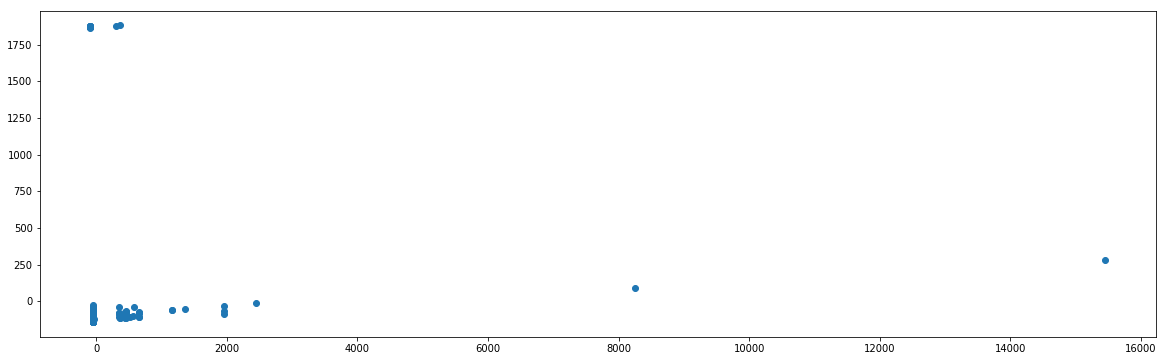

In [28]:
def plot_houses():
    train_features, dev_features = get_regression_features_with_dummy()
    print(train_features.shape)
    pca = PCA(n_components=2)
    train_features_d2 = pca.fit_transform(train_features)
    plt.figure(figsize = (20, 6))
    plt.scatter(train_features_d2[:,0], train_features_d2[:,1]) # most of the houses are very similar to each other
    plt.show()
plot_houses()

# Benchmark Algorithms

Here we produce three benchmark algorithms. One uses the mean house price as the predictor, one uses the most highly correlated feature to predict the house price while the other just puts all of the features into a regression to predict the house price. 

The function below is used to calculate the RMSE of the logarithm of the predicted and actual house prices. From our EDA above, we have chosen to predict the logarithm of the house price directly and will be doing that by default.

In [30]:
def calc_rmse(actual, predicted, log_input=True):
    '''
    evaluate the root mean squared error between the logarithms of the two prices (this is what Kaggle uses).
    log_input = False means actual and predicted are raw sale prices
    log_input = True means actual and predicted are the logarithm of the sale prices
    '''
    if not log_input:
        # make the predictions at least 0
        predicted = np.clip(predicted, 0, None)
        rmse = sqrt(mean_squared_error(np.log1p(actual), np.log1p(predicted)))
        return rmse
    else:
        rmse = sqrt(mean_squared_error(actual, predicted))
        return rmse

rmse_scorer = make_scorer(calc_rmse, greater_is_better=False)

dev_results = {} # store all the results
def store_dev_results(results):
    model_name, rmse = results
    dev_results[model_name] = rmse

## Mean Predictor
For the predictor just use the mean sale price of the training data

In [31]:
def run_mean_predictor_benchmark():
    mean_sale_price = np.mean(train_sale_prices_log)
    print('The mean log home sale price is {:.2f}.'.format(mean_sale_price))
    rmse_train = calc_rmse(train_sale_prices_log, [mean_sale_price for i in range(train_predictors.shape[0])], True)    
    rmse_dev = calc_rmse(dev_sale_prices_log, [mean_sale_price for i in range(dev_predictors.shape[0])], True)
    print('The rmse of the predictions on the train dataset is: {:.6f}.'.format(rmse_train))
    print('The rmse of the predictions on the dev dataset is: {:.6f}.'.format(rmse_dev))
    store_dev_results(('Regression Mean (Benchmark)',rmse_dev))
    
run_mean_predictor_benchmark()

The mean log home sale price is 12.03.
The rmse of the predictions on the train dataset is: 0.398267.
The rmse of the predictions on the dev dataset is: 0.401879.


## Most Correlated Feature
Run a simple regression with the most correlated numeric feature.

GrLivArea = "Above grade (ground) living area square feet"

In [32]:
def run_most_correlated_benchmark():
    # correlations with sale price will be in the first row
    sale_price_correlations = np.corrcoef(df_train[['LogSalePrice'] + numeric_features], rowvar=False)[0]
    most_correlated_numeric_feature_index = np.nanargmax(np.abs(sale_price_correlations[1:]))
    most_correlated_numeric_feature = numeric_features[most_correlated_numeric_feature_index]
    print('The most correlated numeric feature is {} with a correlation of {:.6f}.'.format(most_correlated_numeric_feature, sale_price_correlations[most_correlated_numeric_feature_index+1]))
    
    # run linear regression
    lr = LinearRegression()
    lr.fit(train_predictors[most_correlated_numeric_feature].values.reshape(-1, 1), train_sale_prices_log)
    print('The coefficient of {} is {:.6f}.'.format(most_correlated_numeric_feature, lr.coef_[0]))
    print('The intercept is {:.6f}.'.format(lr.intercept_))
    
    # calculate rmse
    train_predictions = lr.predict(train_predictors[most_correlated_numeric_feature].values.reshape(-1,1))
    dev_predictions = lr.predict(dev_predictors[most_correlated_numeric_feature].values.reshape(-1,1))
    rmse_train = calc_rmse(train_sale_prices_log, train_predictions)
    rmse_dev = calc_rmse(dev_sale_prices_log, dev_predictions)
    print('The rmse of the predictions on the training dataset is: {:.6f}.'.format(rmse_train))
    print('The rmse of the predictions on the dev dataset is: {:.6f}.'.format(rmse_dev))
    
    store_dev_results(('Regression Most Corr (Benchmark)', rmse_dev))

run_most_correlated_benchmark()

The most correlated numeric feature is LogGrLivArea with a correlation of 0.739279.
The coefficient of LogGrLivArea is 0.882462.
The intercept is 5.612746.
The rmse of the predictions on the training dataset is: 0.268193.
The rmse of the predictions on the dev dataset is: 0.283872.


## Regression with All Features
We run a simple regression using all features.

In [36]:
def full_linear_regression_benchmark():
    train_regression_features, dev_regression_features = get_regression_features_with_dummy()

    # run linear regression
    lr = LinearRegression()
    lr.fit(train_regression_features, train_sale_prices_log)
    dev_predictions = lr.predict(dev_regression_features)

    rmse_dev = calc_rmse(dev_sale_prices_log, dev_predictions)
    print('The rmse of the predictions on the training dataset is: {:.6f}.'.format(calc_rmse(train_sale_prices_log, lr.predict(train_regression_features))))
    print('The rmse of the predictions on the dev dataset is: {:.6f}.'.format(rmse_dev))
    
    top_coef = np.argmax(np.abs(lr.coef_))
    print('The feature with the highest weight is {} (coefficient of {:.0f}).'.format(train_regression_features.columns.tolist()[top_coef], lr.coef_[top_coef]))
    store_dev_results(('Regression All (Benchmark)', rmse_dev))
    return lr
lr = full_linear_regression_benchmark()

The rmse of the predictions on the training dataset is: 0.079536.
The rmse of the predictions on the dev dataset is: 0.236741.
The feature with the highest weight is PoolQC_None (coefficient of 32).


Seems like houses with no pool fit the best! Since most houses do not have pools, this seems to make some sense. However, this is probably an indication of over-fitting since the expected feature like living area isn't showing up at the top.


# Improving the Algorithm

For the next section, we want to improve our algorithm by looking to improve our linear regression algorithm as well as trying other algorithms.

Below is a code snippet that is used to run cross-validation for a given predictor and set of parameters. We also provide an option to set whether the regressor should predict the raw price or the logarithm of the price.

In [34]:
def run_cv(regressor, parameters, predict_log=True, model_name = '<None>'):
    train_features, dev_features = get_regression_features_with_dummy()
    cv = GridSearchCV(regressor, parameters, scoring=rmse_scorer)
    if predict_log:
        cv.fit(train_features, train_sale_prices_log)
    else:
        cv.fit(train_features, train_sale_prices)
    dev_predictions = cv.best_estimator_.predict(dev_features)
    train_predictions = cv.best_estimator_.predict(train_features)
    rmse_dev = calc_rmse(dev_sale_prices_log, dev_predictions, predict_log)
    rmse_train = calc_rmse(train_sale_prices_log, train_predictions, predict_log)
    print('The model that had the best param:', cv.best_params_)
    print('The rmse of the predictions on the training dataset is: {:.6f}.'.format(rmse_train))
    print('The rmse of the predictions on the dev dataset is: {:.6f}.'.format(rmse_dev))
    store_dev_results((model_name, rmse_dev))
    return cv

## Linear Regression
To better diagnose and improve the linear regression predictor, we perform a couple of tasks. First, we will scale all of the numeric features to get a more normalized set of coefficients. WIn addition, we will try to prune the features using methods such as Principal Component Analysis, hand-curating a set of features, and Lasso Regression to reduce the feature space.

#### Scaling

Scaling is a technique often used to standardize the coefficients on the features. Here again we see large evidence for overfitting. The rmse on the training dataset is very low while that on the dev dataset is very high. Some of the top features here have coefficients way over 1 million, which given that we are working in a log-space, is very large. We also notice that in this case, the rmse is a lot larger than the unscaled features. This perhaps seems to indicate that scaling may not be appropriate here, perhaps because our features do not necessarily follow normal distributions.

In [37]:
def scaling_features():
    train_features, dev_features = get_regression_features_with_dummy()
    ss, train_features, dev_features = scale_features(train_features, dev_features)

    lr = LinearRegression()
    lr.fit(train_features, train_sale_prices_log)
    dev_predictions = lr.predict(dev_features)
    rmse_train = calc_rmse(train_sale_prices_log, lr.predict(train_features))
    rmse_dev = calc_rmse(dev_sale_prices_log, dev_predictions)
    print('The rmse of the predictions on the train dataset is: {:.6f}.'.format(rmse_train))
    print('The rmse of the predictions on the dev dataset is: {:.6f}.'.format(rmse_dev))

    lr_coefs = zip(train_features.columns.tolist(), lr.coef_)
    lr_coefs_sorted = sorted(lr_coefs, key=lambda x: np.abs(x[1]), reverse=True)
    print('Feature              | Coefficient')
    print('--------------------------------------------')
    for f, coef in lr_coefs_sorted[0:10]:
        print('{:20} | {:.0f}'.format(f, coef))
scaling_features()

The rmse of the predictions on the train dataset is: 0.082096.
The rmse of the predictions on the dev dataset is: 72709732770.331055.
Feature              | Coefficient
--------------------------------------------
GarageType_None      | -2630116209562
BsmtCond_None        | -1821961702110
RemodelAge           | 1817809099377
YearRemodAdd         | 1814928582377
GarageFinish_None    | 1806253162529
GarageQual_None      | 1789663753060
BuiltAge             | -1507703400513
YearBuilt            | -1505331277227
GarageCond_None      | -965800706027
BsmtExposure_None    | 883203618696


#### Lasso, Ridge, and ElasticNet
To combat overfitting, we will try using Lasso, Ridge, and ElasticNet regression to prune features. Here it seems the ridge method performs the best. Looking at the top features from the Lasso method, it looks like while some features make sense (e.g. area of living space), others are less intuitive (e.g. a negative coefficient on pool area).

In [38]:
# lasso
def run_lasso():
    alphas = [0.01, 0.05, 0.1, 0.5, 1, 10, 100, 200, 300, 500]
    cv = run_cv(Lasso(tol=0.01), {'alpha':alphas}, model_name = 'Regression Lasso')
    coefs = cv.best_estimator_.coef_
    train_features, dev_features = get_regression_features_with_dummy()
    print('The lasso regression filtered from {} features to {} features.'.format(train_features.shape[1], len(coefs[coefs != 0])))
    print('The coefficients kept in the Lasso regression are:')
    train_feature_cols = train_features.columns.tolist()
    for i,coef in enumerate(coefs):
        if coef != 0:
            print('{:20} {:.6f}'.format(train_feature_cols[i], coef),)
    return cv

# ridge
def run_ridge():
    alphas = [1, 10, 100, 200, 300, 500]
    cv = run_cv(Ridge(tol=0.01), {'alpha':alphas}, model_name = 'Regression Ridge')
    return cv

# ElasticNet
def run_elasticnet():
    alphas = [1, 10, 100, 200, 300, 500]
    l1_ratios = [i/10. for i in range(11)]
    cv = run_cv(ElasticNet(tol=0.01), {'alpha':alphas, 'l1_ratio': l1_ratios}, model_name = 'Regression ElasticNet')
    return cv

# hide warnings of not converging
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    print('--Lasso--')
    cv_lasso = run_lasso()
    print('--Ridge--')
    cv_ridge = run_ridge()
    print('--ElasticNet--')
    cv_elasticnet = run_elasticnet()

--Lasso--
The model that had the best param: {'alpha': 0.01}
The rmse of the predictions on the training dataset is: 0.164238.
The rmse of the predictions on the dev dataset is: 0.182425.
The lasso regression filtered from 298 features to 26 features.
The coefficients kept in the Lasso regression are:
Foundation_CBlock    -0.004471
OverallQual_8        0.001980
ExterQual_TA         -0.026339
KitchenQual_TA       -0.025732
FireplaceQu_Gd       0.022688
GarageCars           0.057221
YearBuilt            0.002844
Fireplaces           0.057635
LogLotArea           0.046726
TotRmsAbvGrd         0.033716
ScreenPorch          0.000468
GarageYrBlt          0.000043
LogMasVnrArea        0.003580
LotFrontage          0.001518
LogTotalBsmtSF       0.023930
LogWoodDeckSF        0.006601
LogOpenPorchSF       0.009008
RemodelAge           -0.003842
Log2ndFlrSF          0.000832
Log1stFlrSF          0.026869
3SsnPorch            0.000022
BuiltAge             -0.000037
MiscVal              -0.000004
E

#### PCA - Dimensionality Reduction

Next we try to use PCA to help reduce dimensionality. In the graph below we can see that using PCA helps with a minimum rmse of 0.155, but if we include too many components the rmse starts increasing again. 

We found a minimum rmse of 0.155189 when using 140 dimensions


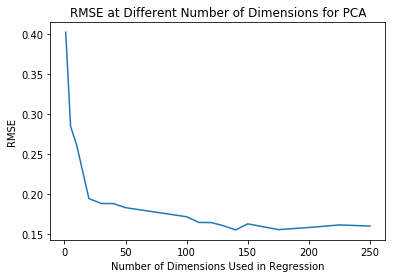

In [39]:
def run_pca_regression(n_components):
    train_features, dev_features = get_regression_features_with_dummy()
    pca = PCA(n_components=n_components)
    train_features_d2 = pca.fit_transform(train_features)
    dev_features_d2 = pca.transform(dev_features)
    
    lr = LinearRegression()
    lr.fit(train_features_d2, train_sale_prices_log)
    dev_predictions = lr.predict(dev_features_d2)
    rmse = calc_rmse(dev_sale_prices_log, dev_predictions)
    return rmse
n_components_to_try = [1, 2, 5, 10, 20, 30, 40, 50, 100, 110, 120, 130, 140, 150, 175, 200, 225, 250]
rmses = [run_pca_regression(i) for i in n_components_to_try]
min_index = np.argmin(rmses)
print('We found a minimum rmse of {:.6f} when using {} dimensions'.format(rmses[min_index], n_components_to_try[min_index]))
store_dev_results(('Regression PCA, n='+ str(n_components_to_try[min_index]), rmses[min_index]))

plt.plot(n_components_to_try, rmses)
plt.title('RMSE at Different Number of Dimensions for PCA')
plt.xlabel('Number of Dimensions Used in Regression')
plt.ylabel('RMSE')
plt.show()

### Hand-Curated Features
Finally, we look to reduce the number of features by hand-curating the features. We have chosen a set of features that we think make sense from a theoretical point of view and also have a high correlation with the outcome variable. The rmse is fairly low compared to the benchmarks, though not as low as some of the other more automatic methods.


In [40]:
def lr_hand_curated():
 
    cols_of_interest = ['LogGrLivArea', 
                        'Log1stFlrSF', 
                        'LogLotArea',
                        'RemodelAge',
                        'TotRmsAbvGrd',
                        'FullBath',
                        'Fireplaces',
                        'GarageCars',
                        'OverallQual']
    
    # run linear regression
    lr = LinearRegression()
    lr.fit(df_train[cols_of_interest], train_sale_prices_log)
    
    # calc rmse
    train_predictions = lr.predict(df_train[cols_of_interest])
    dev_predictions = lr.predict(df_dev[cols_of_interest])
    rmse_train = calc_rmse(train_sale_prices_log, train_predictions)
    print('The rmse of the predictions on the train dataset is: {:.6f}.'.format(rmse_train))
    
    rmse_dev = calc_rmse(dev_sale_prices_log, dev_predictions)
    print('The rmse of the predictions on the dev dataset is: {:.6f}.'.format(rmse_dev))
    store_dev_results(('Regression Hand-Curated', rmse_dev))
    
lr_hand_curated()

The rmse of the predictions on the train dataset is: 0.154210.
The rmse of the predictions on the dev dataset is: 0.174061.


## Random Forest

In [41]:
def run_random_forest_cv():
    # We searched across this space. To speed up computation, we put down the best estimator.
#     n_estimators = [10, 100, 200, 400]
#     max_depths = [1, 5, 10, 15]
#     min_samples_splits = [2, 5]
    n_estimators = [200]
    max_depths = [15]
    min_samples_splits = [2]
    cv = run_cv(RandomForestRegressor(), {'n_estimators':n_estimators, 'max_depth':max_depths, 'min_samples_split':min_samples_splits}, model_name = 'Random Forest')
    
    train_features, dev_features = get_regression_features_with_dummy()
    cv_feature_importances = zip(train_features.columns.tolist(), cv.best_estimator_.feature_importances_)
    cv_feature_importances_sorted = sorted(cv_feature_importances, key=lambda x: np.abs(x[1]), reverse=True)
    print('Feature              | Feature Importance')
    print('-----------------------------------------')
    for f, coef in cv_feature_importances_sorted[0:10]:
        print('{:20} | {:.6f}'.format(f, coef))
    return cv
cv_randomforest = run_random_forest_cv()

The model that had the best param: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 200}
The rmse of the predictions on the training dataset is: 0.055529.
The rmse of the predictions on the dev dataset is: 0.148101.
Feature              | Feature Importance
-----------------------------------------
LogGrLivArea         | 0.335386
BuiltAge             | 0.083728
GarageCars           | 0.079556
ExterQual_TA         | 0.072965
LogTotalBsmtSF       | 0.061797
YearBuilt            | 0.045170
LogLotArea           | 0.027131
LogGarageArea        | 0.024963
CentralAir_Y         | 0.021679
Log1stFlrSF          | 0.020903


## Gradient Boosting

In [42]:
def run_gradient_boosting_cv():
    # We searched across this space. To speed up computation, we put down the best estimator.
#     loss = ['ls', 'lad', 'huber']
#     learning_rate = [0.05, 0.1, 0.2]
#     n_estimators = [100, 200, 300, 400]
#     max_depth = [2,5,10]
    loss = ['huber']
    learning_rate = [0.1]
    n_estimators = [300]
    max_depth = [5]
    
    
    cv = run_cv(GradientBoostingRegressor(), {'loss':loss, 'learning_rate':learning_rate, 'n_estimators':n_estimators, 'max_depth':max_depth}, model_name = 'Gradient Boosting')
    train_features, dev_features = get_regression_features_with_dummy()
    cv_feature_importances = zip(train_features.columns.tolist(), cv.best_estimator_.feature_importances_)
    cv_feature_importances_sorted = sorted(cv_feature_importances, key=lambda x: np.abs(x[1]), reverse=True)
    print('Feature              | Feature Importance')
    print('-----------------------------------------')
    for f, coef in cv_feature_importances_sorted[0:10]:
        print('{:20} | {:.6f}'.format(f, coef))
    return cv
cv_gradientboosting = run_gradient_boosting_cv()

The model that had the best param: {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 5, 'n_estimators': 300}
The rmse of the predictions on the training dataset is: 0.017178.
The rmse of the predictions on the dev dataset is: 0.148225.
Feature              | Feature Importance
-----------------------------------------
LogGrLivArea         | 0.071465
LogLotArea           | 0.062311
LogBsmtUnfSF         | 0.041234
LogTotalBsmtSF       | 0.036988
LogGarageArea        | 0.032423
Log1stFlrSF          | 0.029332
BuiltAge             | 0.028601
LogOpenPorchSF       | 0.028404
LotFrontage          | 0.026960
LogBsmtFinSF1        | 0.024736


## XGBoost
A regularized implementation of gradient boosting.

In [43]:
def run_xgboost_cv():
    # We searched across this space. To speed up computation, we put down the best estimator.
#     learning_rate = [0.05, 0.1, 0.2]
#     n_estimators = [100, 200, 300, 400]
#     max_depth = [2,3,5]
    
    learning_rate = [0.1]
    max_depth = [2]
    n_estimators = [300]
    
    cv = run_cv(XGBRegressor(), {'learning_rate':learning_rate, 'n_estimators':n_estimators, 'max_depth':max_depth}, model_name = 'XGBoost')
    train_features, dev_features = get_regression_features_with_dummy()
    cv_feature_importances = zip(train_features.columns.tolist(), cv.best_estimator_.feature_importances_)
    cv_feature_importances_sorted = sorted(cv_feature_importances, key=lambda x: np.abs(x[1]), reverse=True)
    print('Feature              | Feature Importance')
    print('-----------------------------------------')
    for f, coef in cv_feature_importances_sorted[0:10]:
        print('{:20} | {:.6f}'.format(f, coef))
    return cv
cv_xgboost = run_xgboost_cv()

The model that had the best param: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300}
The rmse of the predictions on the training dataset is: 0.076858.
The rmse of the predictions on the dev dataset is: 0.140175.
Feature              | Feature Importance
-----------------------------------------
LogGrLivArea         | 0.076651
LogLotArea           | 0.055425
LogOpenPorchSF       | 0.037736
GarageYrBlt          | 0.033019
LogTotalBsmtSF       | 0.029481
Log1stFlrSF          | 0.028302
LogBsmtFinSF1        | 0.025943
LogGarageArea        | 0.024764
YearBuilt            | 0.022406
BuiltAge             | 0.022406


From the section above, we see that while ridge regression did well. We could improve the performance even further using methods such as xgboost, which cuts the dev dataset error rate even further. Overall, we found that all methods did some slight overfitting (the rmse is nearly double if not more on the dev dataset compared to the training dataset). 

Also, when looking at the top features across the methods, we find that many of them are what we expected and make sense. For example, for xgboost, we find that the above grade living area, lot area, and how long the house is comprise three of the top features.

## Meta-Models

In this section, we will try to see if we can improve our performance by combining pre-existing models.

### Average Meta Model

To start, we will try to take a simple average of our ridge regression, random forest, gradient boosting, and xgboost algorithms. This seems to improve our performance as shown in the results.

In [44]:
def run_meta_mean():
    train_features, dev_features = get_regression_features_with_dummy()
    dev_ridge_pred = cv_ridge.best_estimator_.predict(dev_features)
    dev_gb_pred = cv_gradientboosting.best_estimator_.predict(dev_features)
    dev_xgb_pred = cv_xgboost.best_estimator_.predict(dev_features)
    dev_rf_pred = cv_randomforest.best_estimator_.predict(dev_features)
    dev_predictions = np.mean([dev_ridge_pred, dev_gb_pred, dev_xgb_pred, dev_rf_pred], axis=0)
    rmse = calc_rmse(dev_sale_prices_log, dev_predictions, True)
    print('The rmse of the predictions on the dev dataset is: {:.6f}.'.format(rmse))
    store_dev_results(('Meta Model (Mean)', rmse))
run_meta_mean()

The rmse of the predictions on the dev dataset is: 0.137157.


### Meta Regression Model

Next, we try to run a regression on the predictions of our algorithms. As we can see below, this technique seems to just pick the best model and set its coefficient to one while essentially setting the other predictions to zero. This was not very helpful. The model learned to put most of the weight on gradient boosting (which was probably fit the best to the training data). To try something smarter, we will try to develop a model whose coefficients reflect how well the predictor can predict its dev sample.

In [45]:
def run_meta_regression():
    train_features, dev_features = get_regression_features_with_dummy()

    train_model_preds = pd.DataFrame(index=train_features.index)
    train_model_preds['ridge_pred'] = cv_ridge.best_estimator_.predict(train_features)
    train_model_preds['gb_pred'] = cv_gradientboosting.best_estimator_.predict(train_features)
    train_model_preds['xgb_pred'] = cv_xgboost.best_estimator_.predict(train_features)
    train_model_preds['rf_pred'] = cv_randomforest.best_estimator_.predict(train_features)
    dev_model_preds = pd.DataFrame(index=dev_features.index)
    dev_model_preds['ridge_pred'] = cv_ridge.best_estimator_.predict(dev_features)
    dev_model_preds['gb_pred'] = cv_gradientboosting.best_estimator_.predict(dev_features)
    dev_model_preds['xgb_pred'] = cv_xgboost.best_estimator_.predict(dev_features)
    dev_model_preds['rf_pred'] = cv_randomforest.best_estimator_.predict(dev_features)
    
    lr = LinearRegression()
    lr.fit(train_model_preds, train_sale_prices_log)
    
    print('The coefficients of the learned regression is:')
    print('Feature              | Coefficient')
    print('-----------------------------------------')
    for col, coef in zip(train_model_preds.columns.tolist(), lr.coef_):
        print('{:20} | {:.6f}'.format(col, coef))
    dev_predictions = lr.predict(dev_model_preds)
    rmse = calc_rmse(dev_sale_prices_log, dev_predictions, True)
    print('The rmse of the predictions on the dev dataset is: {:.6f}.'.format(rmse))
    store_dev_results(('Meta Model (Simple Regression)', rmse))

run_meta_regression()

The coefficients of the learned regression is:
Feature              | Coefficient
-----------------------------------------
ridge_pred           | -0.018782
gb_pred              | 1.067429
xgb_pred             | -0.145979
rf_pred              | 0.102899
The rmse of the predictions on the dev dataset is: 0.151366.


### Meta-Model Stacking

To do this, we will split the training data into n folds. We will treat each fold as a mini-dev set, and we will use the remaining data to train and have each model predict the sale price of the mini-dev set. We will then have a meta model train on the models predictions. This will give us n meta models. When it comes time to predict, we will average the output of the n meta models on the dev set. (Idea based on here: https://burakhimmetoglu.com/2016/12/01/stacking-models-for-improved-predictions/)

In [50]:
models_to_stack = ['xgb', 'gb']
# get a new regressor object based on the regressor name
def _get_regressor(name):
    if name == 'lasso':
        return Lasso(alpha=cv_lasso.best_params_['alpha'], tol=0.1)
    if name == 'ridge':
        return Ridge(alpha=cv_ridge.best_params_['alpha'], tol=0.1)
    if name == 'gb':
        return GradientBoostingRegressor(
            loss = cv_gradientboosting.best_params_['loss'],
            learning_rate = cv_gradientboosting.best_params_['learning_rate'],
            n_estimators = cv_gradientboosting.best_params_['n_estimators'],
            max_depth = cv_gradientboosting.best_params_['max_depth']
        )
    if name == 'xgb':
        return XGBRegressor(
            learning_rate = cv_xgboost.best_params_['learning_rate'], 
            n_estimators = cv_xgboost.best_params_['n_estimators'], 
            max_depth = cv_xgboost.best_params_['max_depth']
        )
    if name == 'rf':
        return RandomForestRegressor(
            n_estimators = cv_randomforest.best_params_['n_estimators'],
            max_depth = cv_randomforest.best_params_['max_depth'],
            min_samples_split = cv_randomforest.best_params_['min_samples_split']
        )

def run_meta_stacker():
    train_features, dev_features = get_regression_features_with_dummy()

    # use 10 folds and train
    k_fold = KFold(n_splits=10)
    splits = k_fold.split(train_features, train_sale_prices_log)
    meta_models = []
    for train_indices, test_indices in splits:
        # get splits
        train_X, test_X = train_features.iloc[train_indices], train_features.iloc[test_indices]
        train_y, test_y = train_sale_prices_log.iloc[train_indices], train_sale_prices_log.iloc[test_indices]

        # train models
        name_to_model = { m:_get_regressor(m) for m in models_to_stack}
        for name, model in name_to_model.items():
            model.fit(train_X, train_y)
        
        # make predictions
        model_preds = pd.DataFrame(index=test_X.index)
        for name, model in name_to_model.items():
            model_preds['{}_pred'.format(name)] = model.predict(test_X)
            
        # fit meta model
        lr = LinearRegression()
        lr.fit(model_preds, test_y)
        
        # store all models
        models = name_to_model.copy()
        models['meta_model'] = lr
        meta_models.append(models)
    
    # examine coefficients
    print('Meta Model Coefficients:')
    print()
    for i, models in enumerate(meta_models):
        print('Meta Model {}'.format(i+1))
        print('Feature              | Coefficient')
        print('-----------------------------------------')
        for col, coef in zip(model_preds.columns.tolist(), models['meta_model'].coef_):
            print('{:20} | {:.6f}'.format(col, coef))
        print()
    
    # evaluate on dev data
    meta_model_preds = []
    for models in meta_models:
        
        # make model predictions
        model_preds = pd.DataFrame(index=dev_features.index)
        for name in models_to_stack:
            model_preds['{}_pred'.format(name)] = models[name].predict(dev_features)
        
        # make meta-prediction
        meta_model_preds.append(models['meta_model'].predict(model_preds))
    
    dev_model_preds = np.mean(meta_model_preds, axis=0)
    rmse = calc_rmse(dev_sale_prices_log, dev_model_preds, log_input=True)  
    print('The rmse of the predictions on the dev dataset is: {:.6f}.'.format(rmse))
    store_dev_results(('Meta Model (Stacked Regression)', rmse))
    
run_meta_stacker()

Meta Model Coefficients:

Meta Model 1
Feature              | Coefficient
-----------------------------------------
xgb_pred             | 0.700500
gb_pred              | 0.280254

Meta Model 2
Feature              | Coefficient
-----------------------------------------
xgb_pred             | 0.545687
gb_pred              | 0.508253

Meta Model 3
Feature              | Coefficient
-----------------------------------------
xgb_pred             | 0.447267
gb_pred              | 0.605141

Meta Model 4
Feature              | Coefficient
-----------------------------------------
xgb_pred             | 0.823526
gb_pred              | 0.151903

Meta Model 5
Feature              | Coefficient
-----------------------------------------
xgb_pred             | 0.585280
gb_pred              | 0.435069

Meta Model 6
Feature              | Coefficient
-----------------------------------------
xgb_pred             | 0.641062
gb_pred              | 0.390291

Meta Model 7
Feature              | Coeffici

# Model Results
Aggregating the plots from above, we make a final chart displaying all of the dev data results.

/Users/eugenetang/miniconda3/envs/W207/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.
  import sys


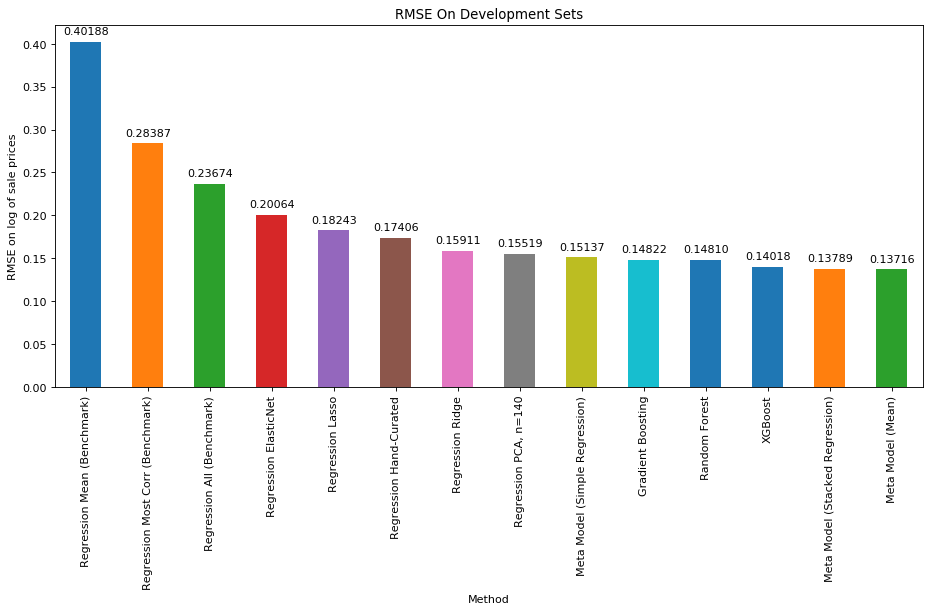

In [51]:
# sort the results dictionary
from collections import OrderedDict
sorted_d = OrderedDict(sorted(dev_results.items(), key=lambda x: x[1], reverse=True))

# setup x,y values
frequencies = list(sorted_d.values())
freq_series = pd.Series.from_array(frequencies)
x_labels = sorted_d.keys()

# Plot the figure: Code below has been copied from:
# https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart
plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
ax = freq_series.plot(kind='bar')
ax.set_title('RMSE On Development Sets')
ax.set_xlabel('Method')
ax.set_ylabel('RMSE on log of sale prices')
ax.set_xticklabels(x_labels)

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    va = 'bottom'

    # If value of bar is negative: Place label below bar
    if y_value < 0:
        # Invert space to place label below
        space *= -1
        # Vertically align label at top
        va = 'top'

    # Use Y value as label and format number with one decimal place
    label = "{:.5f}".format(y_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        ha='center',                # Horizontally center label
        va=va)                      # Vertically align label differently for
                                    # positive and negative values.

# Produce Results for Test Set

We produce results based on the mean-based ensemble method.

In [52]:
# get the features with categorical and ordinal features converted to dummy variables
def get_regression_features_with_dummy_test(train_predictors, test_predictors):
    train_regression_features = pd.DataFrame(index=train_predictors.index)
    test_regression_features = pd.DataFrame(index=test_predictors.index)
    
    # setup categorical/ordinal features
    for feature in (categorical_features + ordinal_features):

        # get dummies
        train_feature_dummies = pd.get_dummies(train_predictors[feature], prefix=feature, drop_first=True)
        test_feature_dummies = pd.get_dummies(test_predictors[feature], prefix=feature, drop_first=True)

        # only take the columns from the training dataset
        for col in train_feature_dummies.columns.tolist():
            train_regression_features[col] = train_feature_dummies[col]
            if col in test_feature_dummies: 
                test_regression_features[col] = test_feature_dummies[col]
            else:
                # if the test dataset doesn't have the column, fill it with zeroes
                test_regression_features[col] = 0

    # add numeric features        
    for col in numeric_features:
        train_regression_features[col] = train_predictors[col]
        test_regression_features[col] = test_predictors[col]
    
    return train_regression_features, test_regression_features

In [53]:
def generate_test_set():
    models = ['ridge', 'gb', 'xgb', 'rf']
    
    full_train_predictors = pd.concat([train_predictors, dev_predictors])
    full_train_sale_price_log = pd.concat([train_sale_prices_log, dev_sale_prices_log])
    train_features, test_features = get_regression_features_with_dummy_test(full_train_predictors, test_predictors)
    
    model_preds = []
    for model_name in models:
        model = _get_regressor(model_name)
        model.fit(train_features, full_train_sale_price_log)
        model_preds.append(model.predict(test_features))
    test_pred = np.mean(model_preds, axis=0)
        
    test_submission = pd.DataFrame(index=test_features.index)
    test_submission['Id'] = df_test['Id']
    # the predictions are the logarithm of the sale price, so take the exponent again
    test_submission['SalePrice'] = np.exp(test_pred) 
    test_submission.to_csv('submission.csv',index=False)
generate_test_set()

On Kaggle, we achieved a score of 0.13826.